# Stacked LSTMs for Time Series Regression

We'll now build a slightly deeper model by stacking two LSTM layers using the Quandl stock price data (see the stacked_lstm_with_feature_embeddings notebook for implementation details). Furthermore, we will include features that are not sequential in nature, namely indicator variables for identifying the equity and the month.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd 
pd.__version__

'1.2.4'

In [2]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd

from scipy.stats import spearmanr

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape, BatchNormalization
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
idx = pd.IndexSlice
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
results_path = Path('results', 'lstm_embeddings')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Data

Data produced by the notebook [build_dataset](00_build_dataset.ipynb).

In [6]:
data = pd.read_hdf('data.h5', 'returns_weekly').drop('label', axis=1)

In [7]:
data['ticker'] = pd.factorize(data.index.get_level_values('ticker'))[0]

In [8]:
data['month'] = data.index.get_level_values('date').month
data = pd.get_dummies(data, columns=['month'], prefix='month')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1066975 entries, ('A', Timestamp('2009-01-11 00:00:00')) to ('UFPI', Timestamp('2017-12-31 00:00:00'))
Data columns (total 66 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   fwd_returns  1066975 non-null  float64
 1   1            1066975 non-null  float64
 2   2            1066975 non-null  float64
 3   3            1066975 non-null  float64
 4   4            1066975 non-null  float64
 5   5            1066975 non-null  float64
 6   6            1066975 non-null  float64
 7   7            1066975 non-null  float64
 8   8            1066975 non-null  float64
 9   9            1066975 non-null  float64
 10  10           1066975 non-null  float64
 11  11           1066975 non-null  float64
 12  12           1066975 non-null  float64
 13  13           1066975 non-null  float64
 14  14           1066975 non-null  float64
 15  15           1066975 non-null  float64
 16  16           1066

## Train-test split

To respect the time series nature of the data, we set aside the data at the end of the sample as hold-out or test set. More specifically, we'll use the data for 2017.

In [10]:
window_size=52
sequence = list(range(1, window_size+1))
ticker = 1
months = 12
n_tickers = data.ticker.nunique()

In [11]:
train_data = data.loc[idx[:, :'2016'], :]
test_data = data.loc[idx[:, '2017'],:]

For each train and test dataset, we generate a list with three input arrays containing the return series, the stock ticker (converted to integer values), and the month (as an integer), as shown here:

In [12]:
X_train = [
    train_data.loc[:, sequence].values.reshape(-1, window_size , 1),
    train_data.ticker,
    train_data.filter(like='month')
]
y_train = train_data.fwd_returns
[x.shape for x in X_train], y_train.shape

([(946400, 52, 1), (946400,), (946400, 12)], (946400,))

In [13]:
# keep the last year for testing
X_test = [
    test_data.loc[:, list(range(1, window_size+1))].values.reshape(-1, window_size , 1),
    test_data.ticker,
    test_data.filter(like='month')
]
y_test = test_data.fwd_returns
[x.shape for x in X_test], y_test.shape

([(120575, 52, 1), (120575,), (120575, 12)], (120575,))

##  Define the Model Architecture

The functional API of Keras makes it easy to design architectures with multiple inputs and outputs. This example illustrates a network with three inputs, as follows:

- A two stacked LSTM layers with 25 and 10 units respectively
- An embedding layer that learns a 10-dimensional real-valued representation of the equities
- A one-hot encoded representation of the month

This can be constructed using just a few lines - see e.g., 
- the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/), 
- the [LTSM documentation](https://keras.io/layers/recurrent/).

Make sure you are initializing your optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

We begin by defining the three inputs with their respective shapes, as described here:

In [14]:
K.clear_session()

In [15]:
n_features = 1

In [16]:
returns = Input(shape=(window_size, n_features), name='Returns')
tickers = Input(shape=(1,), name='Tickers')
months = Input(shape=(12,), name='Months')

### LSTM Layers

To define stacked LSTM layers, we set the `return_sequences` keyword to `True`. This ensures that the first layer produces an output that conforms to the expected three-dimensional input format. Note that we also use dropout regularization and how the functional API passes the tensor outputs from one layer to the subsequent layer:

In [17]:
lstm1_units = 25
lstm2_units = 10

In [18]:
lstm1 = LSTM(units=lstm1_units, 
             input_shape=(window_size, 
                          n_features), 
             name='LSTM1', 
             dropout=.2,
             return_sequences=True)(returns)

lstm_model = LSTM(units=lstm2_units, 
             dropout=.2,
             name='LSTM2')(lstm1)

### Embedding Layer

The embedding layer requires the `input_dim` keyword, which defines how many embeddings the layer will learn, the `output_dim` keyword, which defines the size of the embedding, and the `input_length` keyword to set the number of elements passed to the layer (here only one ticker per sample). 

To combine the embedding layer with the LSTM layer and the months input, we need to reshape (or flatten) it, as follows:

In [19]:
ticker_embedding = Embedding(input_dim=n_tickers, 
                             output_dim=5, 
                             input_length=1)(tickers)
ticker_embedding = Reshape(target_shape=(5,))(ticker_embedding)

### Concatenate Model components

Now we can concatenate the three tensors and add fully-connected layers to learn a mapping from these learned time series, ticker, and month indicators to the outcome, a positive or negative return in the following week, as shown here:

In [20]:
merged = concatenate([lstm_model, 
                      ticker_embedding, 
                      months], name='Merged')

bn = BatchNormalization()(merged)
hidden_dense = Dense(10, name='FC1')(bn)

output = Dense(1, name='Output')(hidden_dense)

rnn = Model(inputs=[returns, tickers, months], outputs=output)

The summary lays out this slightly more sophisticated architecture with 29,371 parameters, as follows:

In [21]:
rnn.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Returns (InputLayer)            [(None, 52, 1)]      0                                            
__________________________________________________________________________________________________
Tickers (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 52, 25)       2700        Returns[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 5)         11375       Tickers[0][0]                    
______________________________________________________________________________________________

## Train the Model

In [22]:
optimizer =tf.keras.optimizers.Adam()

rnn.compile(loss='mse',
            optimizer=optimizer)

In [23]:
lstm_path = (results_path / 'lstm.regression.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=5,
                              restore_best_weights=True)

In [25]:
training = rnn.fit(X_train,
                   y_train,
                   epochs=50,
                   batch_size=64,
                   validation_data=(X_test, y_test),
                   callbacks=[early_stopping, checkpointer],
                   verbose=1)

Epoch 1/50
14788/14788 [==============================] - 644s 43ms/step - loss: 0.0517 - val_loss: 0.0019

Epoch 00001: val_loss improved from inf to 0.00186, saving model to results/lstm_embeddings\lstm.regression.h5
Epoch 2/50
14788/14788 [==============================] - 616s 42ms/step - loss: 0.0029 - val_loss: 0.0016

Epoch 00002: val_loss improved from 0.00186 to 0.00162, saving model to results/lstm_embeddings\lstm.regression.h5
Epoch 3/50
14788/14788 [==============================] - 761s 51ms/step - loss: 0.0029 - val_loss: 0.0016

Epoch 00003: val_loss improved from 0.00162 to 0.00159, saving model to results/lstm_embeddings\lstm.regression.h5
Epoch 4/50
14788/14788 [==============================] - 624s 42ms/step - loss: 0.0029 - val_loss: 0.0016

Epoch 00004: val_loss improved from 0.00159 to 0.00155, saving model to results/lstm_embeddings\lstm.regression.h5
Epoch 5/50
14788/14788 [==============================] - 857s 58ms/step - loss: 0.0028 - val_loss: 0.0015

Epoc

In [26]:
loss_history = pd.DataFrame(training.history)

## Evaluate model performance

In [27]:
test_predict = pd.Series(rnn.predict(X_test).squeeze(), index=y_test.index)

In [28]:
df = y_test.to_frame('ret').assign(y_pred=test_predict)

In [29]:
by_date = df.groupby(level='date')
df['deciles'] = by_date.y_pred.apply(pd.qcut, q=5, labels=False, duplicates='drop')

In [30]:
ic = by_date.apply(lambda x: spearmanr(x.ret, x.y_pred)[0]).mul(100)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 120575 entries, ('A', Timestamp('2017-01-01 00:00:00')) to ('UFPI', Timestamp('2017-12-31 00:00:00'))
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   ret      120575 non-null  float64
 1   y_pred   120575 non-null  float32
 2   deciles  120575 non-null  int64  
dtypes: float32(1), float64(1), int64(1)
memory usage: 2.9+ MB


In [32]:
test_predict = test_predict.to_frame('prediction')
test_predict.index.names = ['symbol', 'date']
test_predict.to_hdf(results_path / 'predictions.h5', 'predictions')

In [33]:
rho, p = spearmanr(df.ret, df.y_pred)
print(f'{rho*100:.2f} ({p:.2%})')

3.84 (0.00%)


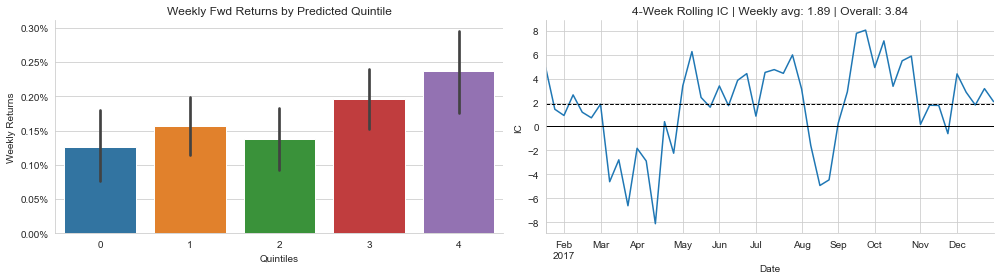

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
sns.barplot(x='deciles', y='ret', data=df, ax=axes[0])
axes[0].set_title('Weekly Fwd Returns by Predicted Quintile')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y))) 
axes[0].set_ylabel('Weekly Returns')
axes[0].set_xlabel('Quintiles')

avg_ic = ic.mean()
title = f'4-Week Rolling IC | Weekly avg: {avg_ic:.2f} | Overall: {rho*100:.2f}'
ic.rolling(4).mean().dropna().plot(ax=axes[1], title=title)
axes[1].axhline(avg_ic, ls='--', c='k', lw=1)
axes[1].axhline(0, c='k', lw=1)
axes[1].set_ylabel('IC')
axes[1].set_xlabel('Date')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'lstm_reg');